In [8]:
!pip install xgboost

In [28]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.3 MB/s eta 0:00:00:00:0100:01


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

In [30]:
casas = pd.read_csv("kc_house_data.csv")

casas.drop(['id'],axis=1,inplace=True)
casas.drop(['date'],axis=1,inplace=True)




In [32]:
casas['bedrooms'] = casas['bedrooms'].replace([33], int(casas[casas['price'] == 640000]['bedrooms'].mean()))

In [33]:
imputer = KNNImputer(n_neighbors=5)
casas[['sqft_basement', 'yr_renovated']] = imputer.fit_transform(casas[['sqft_basement', 'yr_renovated']])

In [34]:
def create_model(data, target, algo, scaler=None):
	if scaler != None:
		X = scaler.fit_transform(data)
	else:
		X = data
	y = target
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
	model = algo
	model.fit(X_train, y_train)
	return(model, X_train, X_test, y_train, y_test)

casas = casas.drop_duplicates()

condition = (casas['sqft_living'] > casas['sqft_lot']) & (casas['floors'] == 1)
for index, row in casas[condition].iterrows():
    casas.at[index, 'sqft_living'] = row['sqft_living15']
    casas.at[index, 'sqft_lot'] = row['sqft_lot15']

condition = (casas['sqft_living15'] > casas['sqft_lot15']) & (casas['floors'] == 1)
for index, row in casas[condition].iterrows():
    casas.at[index, 'sqft_living15'] = row['sqft_living']
    casas.at[index, 'sqft_lot15'] = row['sqft_lot']

scaler = MinMaxScaler()
casas['bedrooms'] = scaler.fit_transform(casas[['bedrooms']])
casas['grade'] = scaler.fit_transform(casas[['grade']])
casas['bathrooms'] = scaler.fit_transform(casas[['bathrooms']])
casas['floors'] = scaler.fit_transform(casas[['floors']])
casas['view'] = scaler.fit_transform(casas[['view']])
casas['sqft_above'] = scaler.fit_transform(casas[['sqft_above']])
casas['yr_built'] = scaler.fit_transform(casas[['yr_built']])
casas['sqft_living'] = scaler.fit_transform(casas[['sqft_living']])
casas['sqft_lot'] = scaler.fit_transform(casas[['sqft_lot']])
casas['sqft_living15'] = scaler.fit_transform(casas[['sqft_living15']])
casas['sqft_lot15'] = scaler.fit_transform(casas[['sqft_lot15']])
casas['condition'] = scaler.fit_transform(casas[['condition']])
casas['sqft_basement'] = scaler.fit_transform(casas[['sqft_basement']])
casas['yr_renovated'] = scaler.fit_transform(casas[['yr_renovated']])
casas['zipcode'] = scaler.fit_transform(casas[['zipcode']])
casas['lat'] = scaler.fit_transform(casas[['lat']])
casas['long'] = scaler.fit_transform(casas[['long']])

# Especificar colunas de features (X) e coluna alvo (y)
features = casas.drop("price", axis=1)  # Remova a coluna alvo "price" das features
target = casas["price"]


Modelo: RandomForestRegressor
Mean Squared Error (MSE): 16126998837.488863
R2 (Test) : 0.8790481315162794
R2 (Training) : 0.9828862030859933
--------------------------------------------------


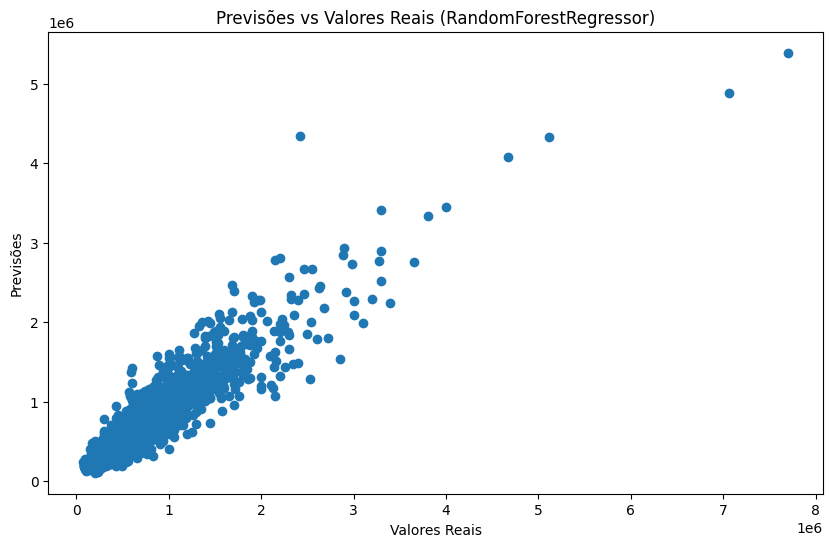

Modelo: LinearRegression
Mean Squared Error (MSE): 39866720596.89674
R2 (Test) : 0.7010011351086625
R2 (Training) : 0.6993626963633316
--------------------------------------------------


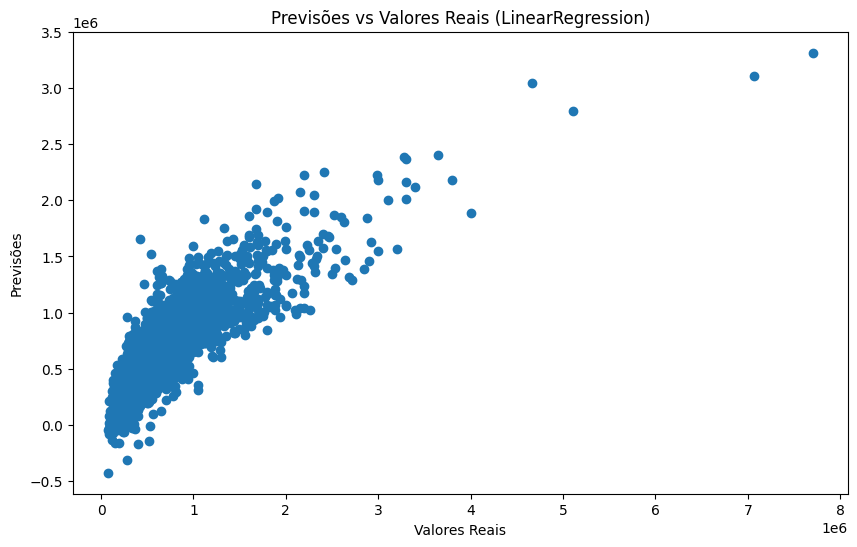

Modelo: SVR
Mean Squared Error (MSE): 140746744384.93735
R2 (Test) : -0.05559514748557692
R2 (Training) : -0.05997739038445249
--------------------------------------------------


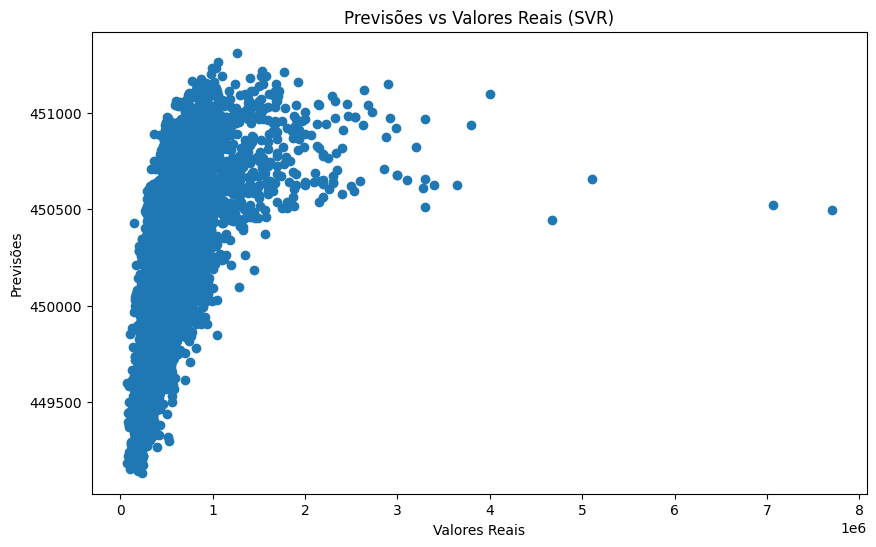

Modelo: GradientBoostingRegressor
Mean Squared Error (MSE): 17150244010.624329
R2 (Test) : 0.871373832233763
R2 (Training) : 0.9022762897489822
--------------------------------------------------


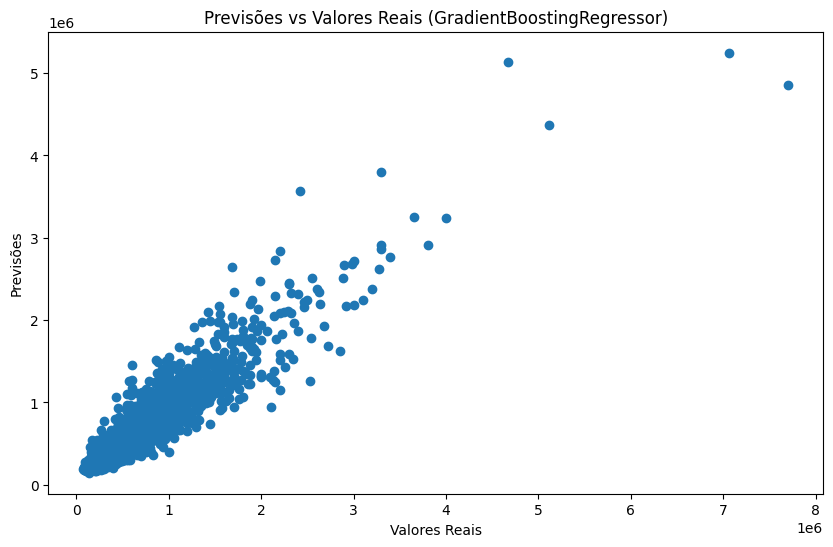

Modelo: KNeighborsRegressor
Mean Squared Error (MSE): 31004343409.879288
R2 (Test) : 0.7674686217612608
R2 (Training) : 0.8611313294783507
--------------------------------------------------


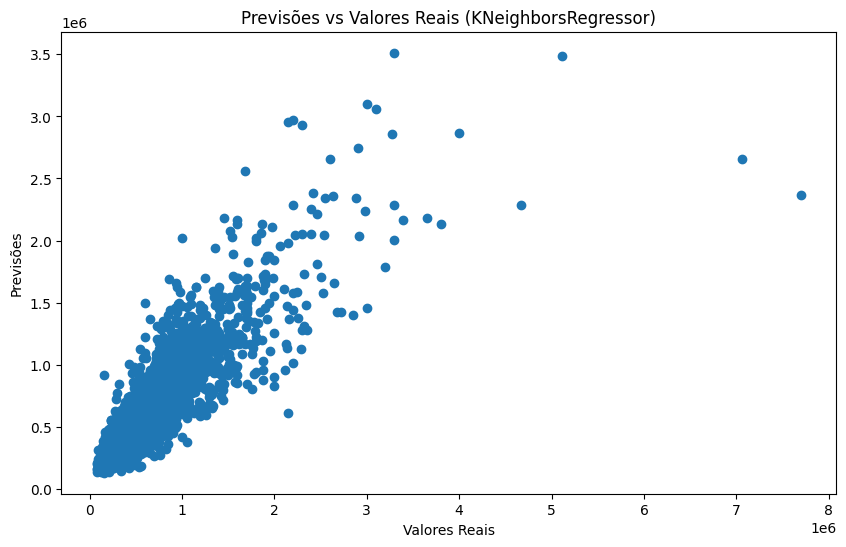

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+14, tolerance: 1.962e+11
  model = cd_fast.enet_coordinate_descent(


Modelo: Lasso
Mean Squared Error (MSE): 39867262163.92507
R2 (Test) : 0.7009970733768645
R2 (Training) : 0.6993517466677845
--------------------------------------------------


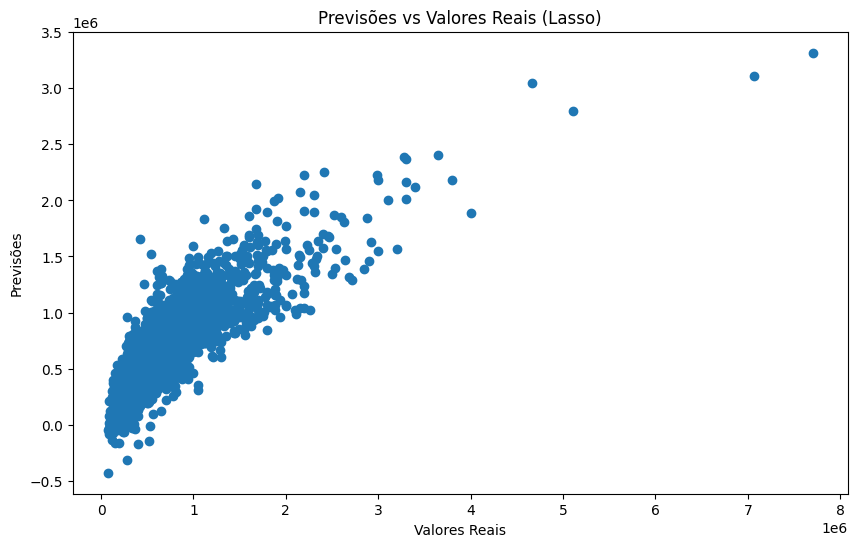

Modelo: Ridge
Mean Squared Error (MSE): 39919867861.71004
R2 (Test) : 0.7006025326750203
R2 (Training) : 0.699320532499552
--------------------------------------------------


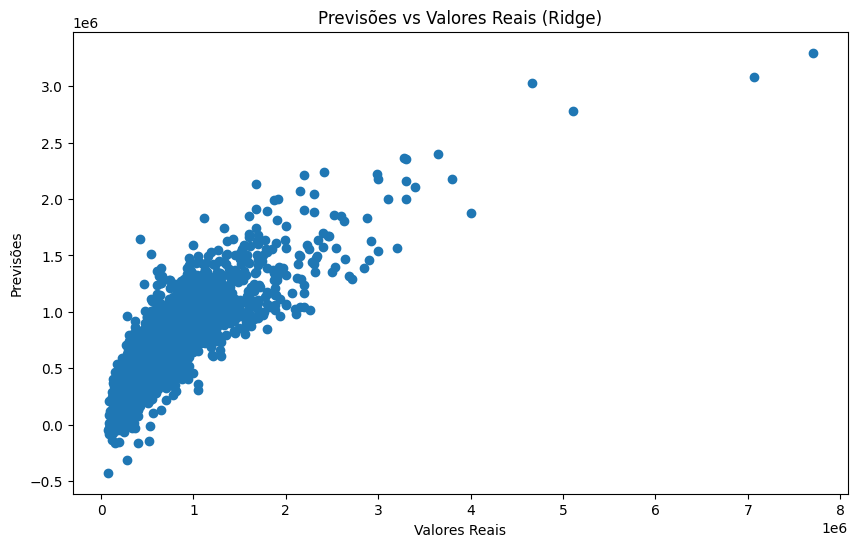

Modelo: ElasticNet
Mean Squared Error (MSE): 118205532693.10605
R2 (Test) : 0.11346306969964937
R2 (Training) : 0.11564512913244729
--------------------------------------------------


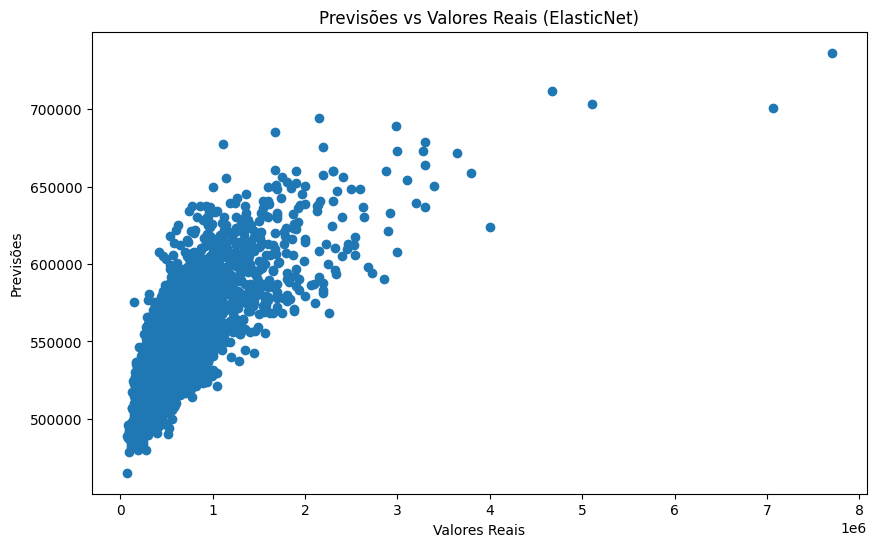

Modelo: XGBRegressor
Mean Squared Error (MSE): 18235334886.450672
R2 (Test) : 0.8632356925694417
R2 (Training) : 0.9790982829750682
--------------------------------------------------


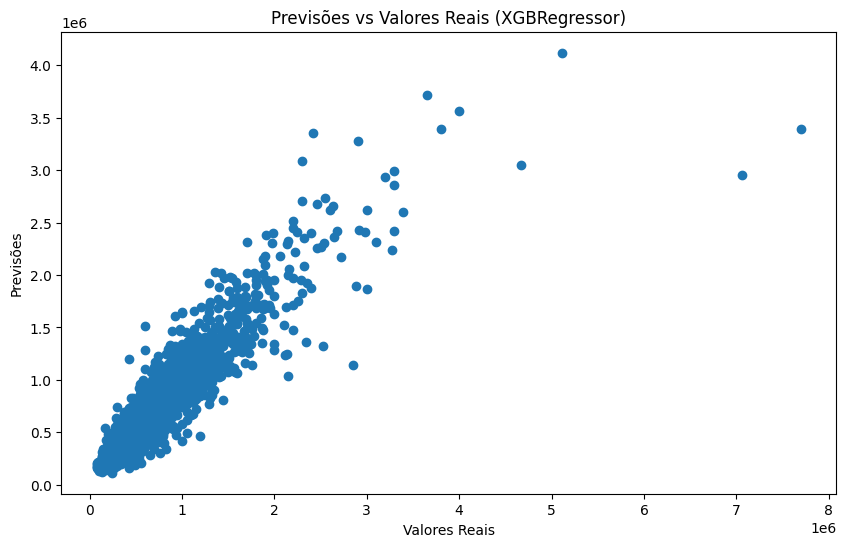

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

# Lista de modelos
modelos = [RandomForestRegressor(), LinearRegression(), SVR(), GradientBoostingRegressor(), KNeighborsRegressor(), Lasso(), Ridge(), ElasticNet(), XGBRegressor()]

for modelo in modelos:
    modelo, X_train, X_test, y_train, y_test = create_model(features, target, modelo, scaler=None)
    
    # Fazendo previsões
    y_pred = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)
    
    # Calculando métricas
    mse = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Imprimindo métricas
    print(f'Modelo: {modelo.__class__.__name__}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R2 (Test) : {r2_test}')
    print(f'R2 (Training) : {r2_train}')
    print('-'*50)

     # Plotando as previsões
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title(f'Previsões vs Valores Reais ({modelo.__class__.__name__})')
    plt.show()

In [36]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score

lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
print("Root Mean Squared Error (Lasso): ", np.sqrt(-cross_val_score(lasso, features, target, cv=10, scoring='neg_mean_squared_error')).mean())

elastic = ElasticNet(alpha=0.001)
print("Root Mean Squared Error (ElasticNet): ", np.sqrt(-cross_val_score(lasso, features, target,  cv=10, scoring='neg_mean_squared_error')).mean())

ridge = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
print("Root Mean Squared Error (Ridge): ", np.sqrt(-cross_val_score(lasso, features, target,  cv=10, scoring='neg_mean_squared_error')).mean())

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370618225914.125, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20046915217428.688, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270361696409455.22, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_mo

Root Mean Squared Error (Lasso):  201800.16080555235


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370618225914.125, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20046915217428.688, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270361696409455.22, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_mo

Root Mean Squared Error (ElasticNet):  201800.16080555235


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370618225914.125, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20046915217428.688, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270361696409455.22, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_mo

Root Mean Squared Error (Ridge):  201800.16080555235


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+14, tolerance: 2.607e+11
  model = cd_fast.enet_coordinate_descent(


/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:00:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (Xgboost):  123809.15574430689
R2 (Teste) : 0.8850352891228804
R2 (Treinamento) : 0.9790982829750682


Text(0.5, 1.0, 'xgboost')

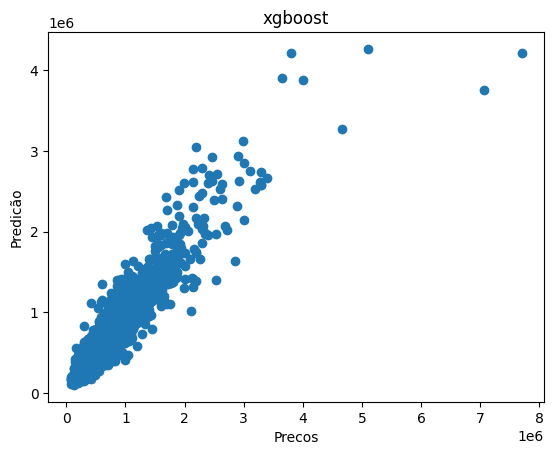

In [37]:
from sklearn import metrics 
regr = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42, silent=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Root Mean Squared Error (Xgboost): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(f'R2 (Teste) : {r2_score(y_test, y_pred)}')
print(f'R2 (Treinamento) : {r2_score(y_true=y_train, y_pred=modelo.predict(X_train))}')

plt.scatter(y_test, y_pred)
plt.xlabel("Precos")
plt.ylabel("Predicão")
plt.title("xgboost")


In [10]:
pred = pd.DataFrame({'Atual': y_test, 'Predição': y_pred})
pred.head()

,Atual,Predição
15075,690000.0,597995.187500
9685,430000.0,486080.687500
10424,109000.0,184971.046875
19015,581000.0,638945.437500
19154,650000.0,531618.750000


In [26]:
real_values = y_test.to_list()
print('Real\t\tPredicted')
for item in range(len(y_pred)):
    print("${0:,.2f}\t${1:,.2f}".format(real_values[item],y_pred[item]))

Real		Predicted
$690,000.00	$597,995.19
$430,000.00	$486,080.69
$109,000.00	$184,971.05
$581,000.00	$638,945.44
$650,000.00	$531,618.75
$292,000.00	$290,822.38
$280,927.00	$338,111.22
$633,000.00	$659,595.38
$425,000.00	$441,843.06
$1,300,000.00	$1,306,226.88
$275,000.00	$376,459.06
$735,000.00	$831,950.00
$485,000.00	$469,759.19
$285,000.00	$289,219.31
$631,000.00	$652,746.81
$200,000.00	$221,673.31
$840,000.00	$608,625.19
$615,000.00	$470,789.06
$631,000.00	$673,440.19
$429,000.00	$245,487.03
$1,045,000.00	$1,133,569.00
$390,000.00	$365,167.44
$425,000.00	$361,829.78
$480,000.00	$705,220.81
$569,000.00	$609,903.12
$455,000.00	$488,933.00
$828,000.00	$798,337.75
$357,000.00	$500,319.19
$299,950.00	$289,560.00
$249,900.00	$252,465.25
$600,000.00	$620,117.69
$335,000.00	$374,599.03
$380,000.00	$224,629.77
$790,000.00	$801,871.38
$430,000.00	$577,893.50
$720,000.00	$696,676.81
$327,000.00	$382,261.78
$1,450,000.00	$1,938,966.75
$500,000.00	$530,455.50
$399,950.00	$354,337.22
$199,500.00	

In [39]:
regressor = CatBoostRegressor(loss_function='RMSE', iterations=1000, depth=3, colsample_bylevel=.4,
                             eval_metric='MAE', subsample=.5, random_state=0, verbose=0, eta=.1)
model, X_train, X_test, y_train, y_test = create_model(features, target, regressor)

In [40]:
y_pred=model.predict(X_test)

print(f'MAE is : {mean_absolute_error(y_test,y_pred)}')
print(f'R2 (Test) is : {r2_score(y_test,y_pred)}')
print(f'R2 (Training) : {r2_score(y_true=y_train, y_pred=model.predict(X_train))}')

MAE is : 67110.91677442749
R2 (Test) is : 0.8925175893296642
R2 (Training) : 0.940527084760585


In [ ]:
real_values = y_test.to_list()
print('Real\t\tPredicted')
for item in range(len(y_pred)):
    print("${0:,.2f}\t${1:,.2f}".format(real_values[item],y_pred[item]))